# Supplementary figure (Discoveries)

In [1]:
experiment_ids = 'f1'
timepoints = 'all'
regions = 'cusanovich_dm6_peaks_1kb'
correction = 'wasp'

In [2]:
label = '_'.join([experiment_ids, timepoints, 'windows'])
wasp_corrected = True if correction == 'wasp' else False

## Imports

In [3]:
# general
import sys
import os

In [4]:
# tools
import numpy as np
import pandas as pd
import scanpy as sc
import scipy
from scipy.stats import probplot

sc.settings.verbosity = 3

In [5]:
# plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
# local
sys.path.append('..')
from utils import settings

## Global variables

In [7]:
DALIHOM_PVAL = 'DALIHOM'
DALIHET_PVAL = 'DALIHET_VAE'
DALIHET_LINEAGE_PVAL = lambda x : 'DALIHET_TIME_%s' % x
DALIJOINT_PVAL = 'DALIJOINT'
DALIJOINT_RHO = 'DALIJOINT_RHO'

## Data files

In [8]:
adata_total = sc.read(os.path.join(settings.DATA_DIR, label, 'total_counts_vae_processed.h5ad'))
adata_total

AnnData object with n_obs × n_vars = 34053 × 25000
    obs: 'exp_id', 'timepoint', 'n_genes', 'n_peaks_by_counts', 'log1p_n_peaks_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_peaks', 'pct_counts_in_top_100_peaks', 'pct_counts_in_top_200_peaks', 'pct_counts_in_top_500_peaks', 'n_counts', 'X_pca_0', 'size_vae', 'time_vae', 'leiden_vae', 'annotation', 'lineage_muscle', 'lineage_nervous'
    var: 'chr', 'start', 'end', 'length', 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'count_variance'
    uns: 'annotation_colors', 'enrichment', 'exp_id_colors', 'leiden', 'leiden_vae_colors', 'neighbors', 'pca', 'rank_genes_groups', 'timepoint_colors', 'umap'
    obsm: 'X_pca', 'X_umap', 'X_vae'
    varm: 'PCs'
    layers: 'vae_peak_activities'
    obsp: 'connectivities', 'distances'

In [9]:
adatas_allelic = dict()
for exp_id in settings.F1_EXP_IDS:
    fname = '_'.join([exp_id, regions, correction, 'allelic_counts.h5ad'])
    adatas_allelic[exp_id] = sc.read(os.path.join(settings.DATA_DIR, label, fname))

In [10]:
cross_colors = dict(zip(adata_total.obs['exp_id'].cat.categories.tolist(), adata_total.uns['exp_id_colors']))

In [11]:
F1_IDS = 'F1-' + pd.read_csv(settings.EXPERIMENT_INFO, sep='\t', index_col=0)['paternal_id']

## Plot settings

In [12]:
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 7
sns.set_style("ticks")

In [13]:
FIGURE_NUMBER = 'supp25'
PANEL_COUNTS = 1

def save_panel(fig):
    global PANEL_COUNTS
    
    fig_dir = 'figures/fig%s' % FIGURE_NUMBER
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    fig.savefig(fig_dir + '/panel_%d.svg' % PANEL_COUNTS, dpi=350)
    PANEL_COUNTS += 1

## Combine results and analyze

In [14]:
# extract p-values for all crosses
df_all = pd.DataFrame()

cols = [
    DALIHET_PVAL, 
    DALIJOINT_PVAL, 
    DALIHOM_PVAL,
]
cols += [c + '_bh' for c in cols]
    
for exp_id, adata in adatas_allelic.items():    
    df_sub = adata.var[cols]    
    df_sub = df_sub.reset_index()
    df_sub['exp_id'] = exp_id        
    df_all = pd.concat([df_all, df_sub], ignore_index=True)

# reorder columns
df_all.columns = ['peak'] + df_all.columns[1:].tolist()
df_all.head()

,peak,DALIHET_VAE,DALIJOINT,DALIHOM,DALIHET_VAE_bh,DALIJOINT_bh,DALIHOM_bh,exp_id
0,chr2L_5261_6261,0.011449,5.652263e-05,3.209529e-05,0.273467,1.062453e-03,6.618294e-04,SS148
1,chr2L_6273_7273,0.204462,2.149947e-01,2.023046e-01,0.648719,4.374031e-01,4.441690e-01,SS148
2,chr2L_7282_8282,0.114362,1.340085e-01,7.619567e-02,0.566850,3.348770e-01,2.453780e-01,SS148
3,chr2L_7938_8938,0.233088,6.004140e-22,1.465500e-21,0.667565,9.609055e-20,2.669641e-19,SS148
4,chr2L_18183_19183,0.747172,4.049562e-18,2.811349e-18,0.911484,5.033937e-16,3.899390e-16,SS148


## QQ Plots by cross

In [15]:
def qqplot(test, testlabel, legend=False):
    df = pd.DataFrame()
    fig, ax = plt.subplots(figsize=(1.8, 1.8))
    for exp_id in df_all['exp_id'].unique():
        (osm, osr), _ = probplot(df_all.query('exp_id == @exp_id')[test].to_numpy(), dist='uniform')
        ax.scatter(
            x=-np.log10(osm), y=-np.log10(osr), 
            label=F1_IDS[exp_id], c=cross_colors[exp_id],
            rasterized=True, s=1)
    ax.plot([0, 5], [0, 5], 'grey', linestyle='--')
    ax.set(
        xlabel='Expected $-\log_{10}$ P',
        ylabel='Observed $-\log_{10}$ P',
        title='QQ-Plot (%s)' % testlabel,
        xticks=[0, 1, 2, 3, 4, 5])
    if legend:
        plt.legend(
            loc='center left',
            bbox_to_anchor=(1, .5), 
            frameon=False)
    sns.despine(trim=True)

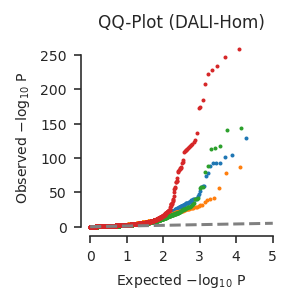

In [16]:
qqplot(DALIHOM_PVAL, 'DALI-Hom')
save_panel(plt.gcf())
plt.show()
plt.close()

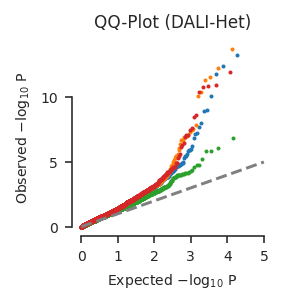

In [17]:
qqplot(DALIHET_PVAL, 'DALI-Het')
save_panel(plt.gcf())
plt.show()
plt.close()

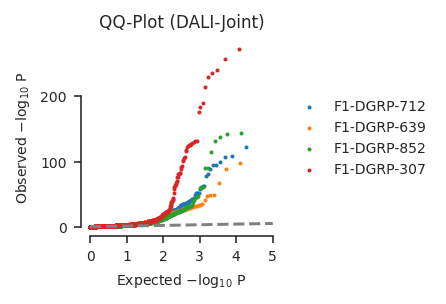

In [18]:
qqplot(DALIJOINT_PVAL, 'DALI-Joint', legend=True)
save_panel(plt.gcf())
plt.show()
plt.close()

## Discoveries by cross

In [19]:
tests_bh = ['%s_bh' % s for s in [DALIHET_PVAL, DALIHOM_PVAL, DALIJOINT_PVAL]]
df_fdr10 = df_all[tests_bh] < .1
df_fdr10['exp_id'] = df_all['exp_id']
discoveries = df_fdr10.groupby('exp_id').sum().reset_index()

In [20]:
def plot_discoveries(test, test_label):
    fig, ax = plt.subplots(figsize=(1.8, 1.2))
    sns.barplot(x='exp_id', y=test + '_bh', data=discoveries, palette=cross_colors, ax=ax)
    ax.set(xlabel='Cross', ylabel='Discoveries at FDR 10%', title=test_label)
    ax.set_xticklabels([F1_IDS[label.get_text()] for label in ax.get_xticklabels()], rotation=30)
    sns.despine()

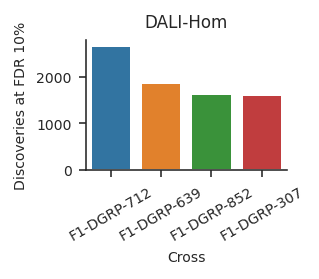

In [21]:
plot_discoveries(DALIHOM_PVAL, 'DALI-Hom')
save_panel(plt.gcf())
plt.show()
plt.close()

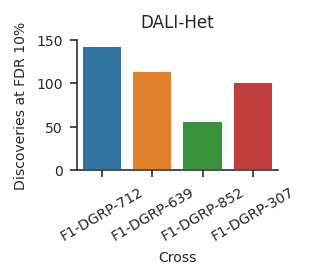

In [22]:
plot_discoveries(DALIHET_PVAL, 'DALI-Het')
save_panel(plt.gcf())
plt.show()
plt.close()

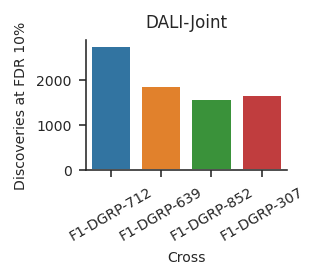

In [23]:
plot_discoveries(DALIJOINT_PVAL, 'DALI-Joint')
save_panel(plt.gcf())
plt.show()
plt.close()